# Sense and Move

In this notebook, let's put all of what we've learned together and see what happens to an initial probability distribution as a robot goes trough cycles of sensing then moving then sensing then moving, and so on! Recall that each time a robot senses (in this case a red or green color)it gains information about its environment, and everytime it moves, it loses some information due to motion uncertainty.


<img src='images/sense_move.png' width=50% height=50% />


First let's include our usual resource imports and display function.

In [5]:
# importing resources
from typing import List
import matplotlib.pyplot as plt
import numpy as np

A helper function for visualizing a distribution.

In [6]:
def display_map(grid: List[float], bar_width: int = 1) -> None:
    """Creates a bar chart to show the probabilities for a robot to 
    be in each of the 1D grid cell.
    """
    if(len(grid) > 0):
        x_labels: range = range(len(grid))
        plt.bar(x_labels, height=grid, width=bar_width, color='b')
        plt.xlabel('Grid Cell')
        plt.ylabel('Probability')
        plt.ylim(0, 1) # range of 0-1 for probability values 
        plt.title('Probability of the robot being at each cell in the grid')
        plt.xticks(np.arange(min(x_labels), max(x_labels)+1, 1))
        plt.show()
    else:
        print('Grid is empty')

### QUIZ: Given the list motions=[1,1], compute the posterior distribution if the robot first senses red, then moves right one, then senses green, then moves right again, starting with a uniform prior distribution, `p`.

`motions=[1,1]` mean that the robot moves right one cell and then right again. You are given the initial variables and the complete `sense` and `move` function, below.

In [7]:
# given initial variables
p: List[float] = [0.2, 0.2, 0.2, 0.2, 0.2]
# the color of each grid cell in the 1D world
world: List[float] = ['green', 'red', 'red', 'green', 'green']
# Z, the sensor reading ('red' or 'green')
measurements: List[float] = ['red', 'green']
pHit: float = 0.6
pMiss: float = 0.2

motions: List[int] = [1,1]
pExact: float = 0.8
pOvershoot: float = 0.1
pUndershoot: float = 0.1


def sense(p: List[float], Z: str) -> List[float]:
    """Takes in a current probability distribution, p, and a sensor reading, Z.
    Returns an nonnormalized distribution after the sensor measurement has been made, q.
    This should be accurate whether Z is 'red' or 'green'.
    
    Args:
        p: Prior probability distribution to sensor measurements
        Z: Cell color
    
    Returns:
        Normalized posterior probability distribution
    """
    q: List[float] = []
    # Iterate through all grid cells
    for prob, cell_color in zip(p, world):
        # check if the sensor reading is equal to the color of the grid cell
        # if so, hit = 1
        # if not, hit = 0
        hit: int = (Z == cell_color)
        # if hit - 1, we multiply the probability with pHit, because (1 - hit) = 0
        # If hit = 0, we multiply the probability with pMis, because (1 - hit) = 1
        q.append(prob * (hit * pHit + (1-hit) * pMiss))

    # Normalize q
    q = (np.array(q) / np.sum(q)).tolist()
    return q


def move(p: List[float], U: int) -> List[float]:
    """We are considering the robot motion in 1D world represented 
    by a cyclic array / list, means when the robot moves 1 step to 
    the right from the last cell of the array it ends up coming to 
    the first cell. In order to model this probability distribution 
    also shifts one step to he right. This function implements that.
    
    Args:
        p: Starting probability distribution
        U: Number of steps for robot motion
    
    Returns:
        Shifted probability distribution resulting from the motion
    """
    q: List[float] = []
    if len(p) == 0:
        return q
    for idx in range(len(p)):
        index: int = (idx - U) % len(p)
        prevIndex: int = (index - 1) % len(p)
        nextIndex: int = (index + 1) % len(p)
        val: float = pExact * p[index]
        val = val + pUndershoot * p[prevIndex]
        val = val + pOvershoot * p[nextIndex]
        q.append(val)
    return q

[0.21157894736842103, 0.1515789473684211, 0.08105263157894739, 0.16842105263157897, 0.3873684210526316]


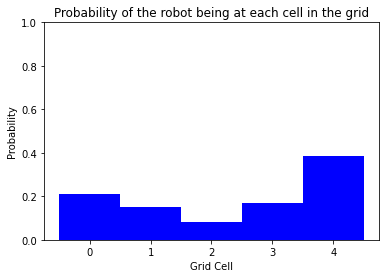

In [8]:
## TODO: Compute the posterior distribution if the robot first senses red, then moves 
## right one, then senses green, then moves right again, starting with a uniform prior distribution.

## print/display that distribution
for mea, mot in zip(measurements, motions):
    p = sense(p=p, Z=mea)
    p = move(p=p, U=mot)

print(p)
display_map(p)

World -> ['green', 'red', 'red', 'green', 'green']
Robot sensed -> ['red', 'green']
Robot moved -> [1, 1]

This was the setting for this experiment. By looking at the probabilities, sensor measurement, and movement patterns let's first make a guess about, what was he initial position of the robot and then verify that thought process with a subsequent experiment.

We guess, that the initial position of the robot was the third red cell. At that point it sensed red and took a step right. Then it sensed green and took a step right. This means it is at the right most green cell at this point. Looking at the probability patterns, `[0.21157894736842103, 0.1515789473684211, 0.08105263157894739, 0.16842105263157897, 0.3873684210526316]` indeed the right most position got the highest probability.

Now let's give ourselves another set of observations to verify this. Following is our state and we just changed the sensor measurements for the robot.

World -> ['green', 'red', 'red', 'green', 'green']
Robot sensed -> ['red', 'red']
Robot moved -> [1, 1]

From the assumed observations our guess is, that the initial starting position of the robot in this case is the second red cell. The final position of the robot would be the fourth green cell and that position would have the highest probability.

[0.07882352941176471, 0.07529411764705884, 0.22470588235294123, 0.4329411764705882, 0.18823529411764706]


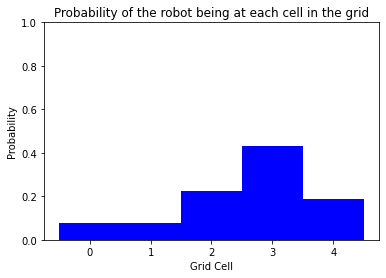

In [11]:
p: List[float] = [0.2, 0.2, 0.2, 0.2, 0.2]
world: List[float] = ['green', 'red', 'red', 'green', 'green']
measurements: List[float] = ['red', 'red']
motions: List[int] = [1,1]

for mea, mot in zip(measurements, motions):
    p = sense(p=p, Z=mea)
    p = move(p=p, U=mot)

print(p)
display_map(p)

And with above experiment our guess is verified.

### Note about Entropy

In general, **entropy measures the amount of uncertainty**. Since the update (`move`) step increases uncertainty, then entropy should increase. The measurement (`sense`) step decreases uncertainty, so entropy should decrease.

Let's look at our current example where the robot could be at five different positions. The maximum uncertainty occurs when all positions have equal probabilities  $[0.2, 0.2, 0.2, 0.2, 0.2]$ 

Following the formula $$\text{Entropy} = \Sigma  (-p \times log(p))$$we get $$-5 \times (.2)\times log(0.2) = 0.699$$

Taking a measurement should decrease uncertainty and thus decrease entropy. Let's say after taking a measurement, the probabilities become <span class="mathquill">[0.05, 0.05, 0.05, 0.8, 0.05]</span>. Now the entropy decreased to 0.338. Hence a measurement step should decrease entropy whereas an update step should increase entropy.